Back to the main [Index](../index.ipynb)

# Post-processing tools for phonons

Is this tutorial, we will explore the tools provided by Abipy for the post-processing of DFPT calculations. Let's start by importing the basic modules we have already used in the previous lessons:


In [1]:
from __future__ import division, print_function, unicode_literals

import abipy.data as abidata
import seaborn  # Activate seaborn settings (optional)

from abipy import abilab
from abipy.abilab import abiopen

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of poping up a new window. 
%matplotlib notebook

# Reading a DDB file in python

In [2]:
ddb_path = "/Users/gmatteo/git_repos/abipy/abipy/test_files/AlAs_444_nobecs_DDB"
ddb = abiopen(ddb_path)
# Remember to close the ddb with ddb.close() when you don't need it anymore!

###### The DDB file has a header, a dict-like object with the most important parameters of the calculation

In [3]:
# To sort the keys in the header and print the list use:
from pprint import pprint
pprint(sorted(list(ddb.header.keys())))

['acell',
 'amu',
 'dilatmx',
 'ecut',
 'ecutsm',
 'intxc',
 'iscf',
 'ixc',
 'kpt',
 'kptnrm',
 'lines',
 'natom',
 'nband',
 'ngfft',
 'nkpt',
 'nspden',
 'nspinor',
 'nsppol',
 'nsym',
 'ntypat',
 'occ',
 'occopt',
 'rprim',
 'sciss',
 'spinat',
 'symafm',
 'symrel',
 'tnons',
 'tolwfr',
 'tphysel',
 'tsmear',
 'typat',
 'usepaw',
 'version',
 'wtk',
 'xred',
 'zion',
 'znucl']


In [4]:
# Use the stadard syntax [] to access the value of a variable in the header.
print("This DDB has been generated with ecut", ddb.header["ecut"], "and amu", ddb.header["amu"])

This DDB has been generated with ecut 2.0 and amu [26.981539, 74.92159]


###### To get the list of $q$-points available in the DDB file:

In [5]:
ddb.qpoints

0) [+0.000, +0.000, +0.000]
1) [+0.250, +0.000, +0.000]
2) [+0.500, +0.000, +0.000]
3) [+0.250, +0.250, +0.000]
4) [+0.500, +0.250, +0.000]
5) [-0.250, +0.250, +0.000]
6) [+0.500, +0.500, +0.000]
7) [-0.250, +0.500, +0.250]

###### A DDB object has a crystalline structure

In [6]:
# Remember that lengths are always given in Angstrom.
print(ddb.structure)

Full Formula (Al1 As1)
Reduced Formula: AlAs
abc   :   3.970101   3.970101   3.970101
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Al    0     0     0
  1  As    0.25  0.25  0.25


# Invoking Anaddb form the DDB object 

The `DdbFile` object provides specialized methods that will invoke anaddb to 
compute important quantities such as the phonon band structure, the phonon density of states etc.
All these methods have a name that begins with the `ana` prefix

###### Plotting phonon bands and DOSes 

In [7]:
# Call anaddb to compute phonon bands and DOS.
# Returnt PHBST and PHDOS netcdf files.
phbstnc, phdosnc = ddb.anaget_phbst_and_phdos_files(ngqpt=None, ndivsm=20, nqsmall=10, 
    asr=2, chneut=1, dipdip=1, dos_method="tetra")

phbands = phbstnc.phbands
phdos = phdosnc.phdos

<IPython.core.display.Javascript object>


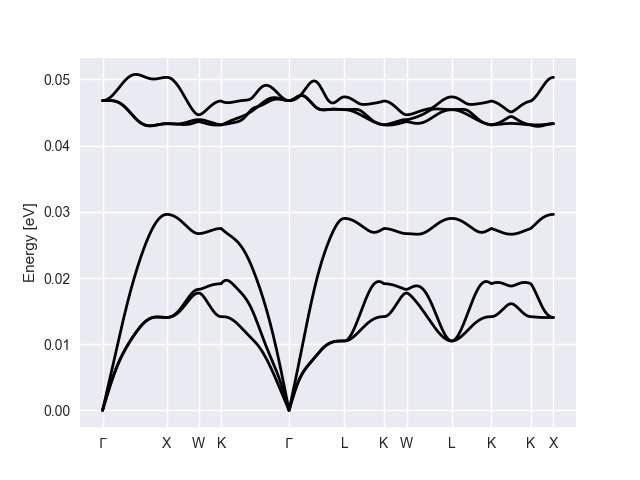

In [8]:
# Plot phonon bands.
phbands.plot();

<IPython.core.display.Javascript object>


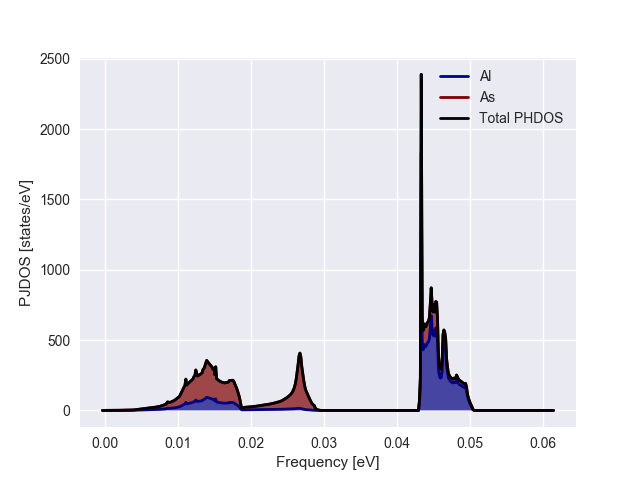

In [9]:
# Plot projected DOS
phdosnc.plot_pjdos_type();

<IPython.core.display.Javascript object>


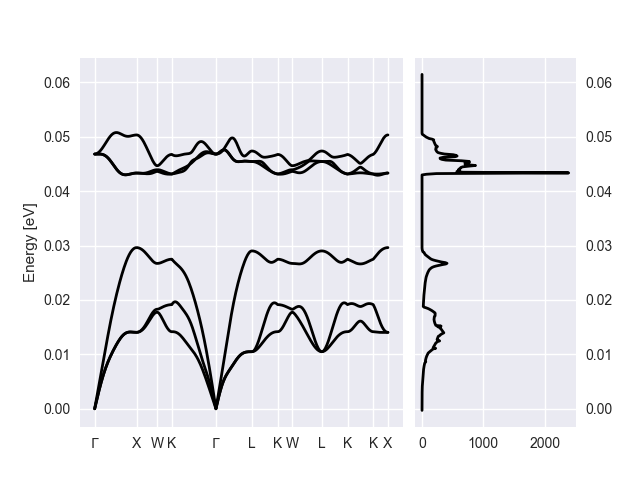

In [10]:
# Plot Phonon bands with DOS.
phbands.plot_with_phdos(phdos);

<IPython.core.display.Javascript object>


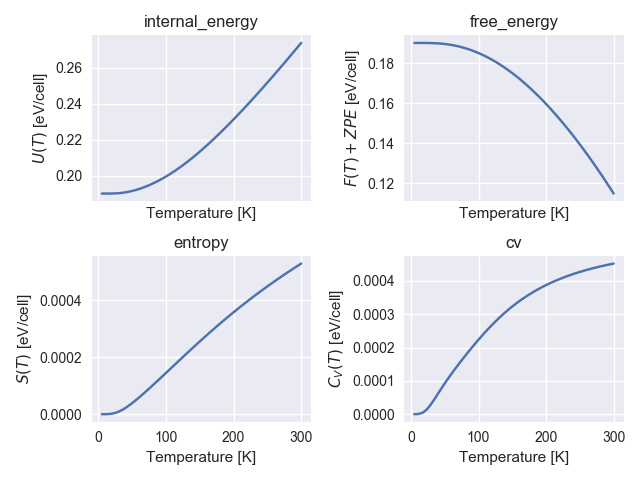

In [12]:
# From the DOS, one can compute thermodinamic properties in the harmonic approximation.
phdos.plot_harmonic_thermo();

In [13]:
zpe = phdos.zero_point_energy
print("Zero-point energy", zpe, zpe.to("Ha"))

Zero-point energy 0.09503886979458234 eV 0.0034926140742158377 Ha


<IPython.core.display.Javascript object>


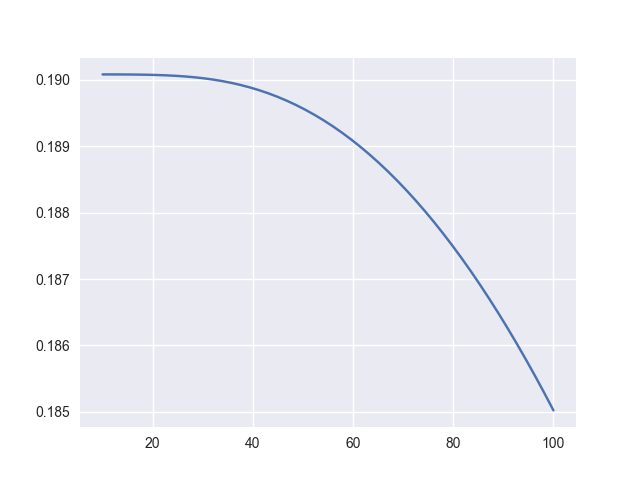

In [14]:
# To get the free energy for a range of temperatures.
tstart, tstop = 10, 100
f = phdos.get_free_energy(tstart=tstart, tstop=tstop)
f.plot();

###### Computing DOSes with different $q$-meshes 

The method `anacompare_phdos` provides a simple interface that allows us to 
compare phonon DOSes computed with different $q$-meshes. 
You only have to provide a list of integers (`nqsmalls`). Each integer defines the number of divisions to be used to 
sample the smallest reciprocal lattice vectors, the other two vectors are sampled such 
that proportions are preserver. 
To calculate four phonon DOSes with increasing number of q-points use:

 Delta(Phdos[0] - Phdos[4]) / Phdos[4]: 4.958856
 Delta(Phdos[1] - Phdos[4]) / Phdos[4]: 3.415114
 Delta(Phdos[2] - Phdos[4]) / Phdos[4]: 0.986188
 Delta(Phdos[3] - Phdos[4]) / Phdos[4]: 0.497099


<IPython.core.display.Javascript object>


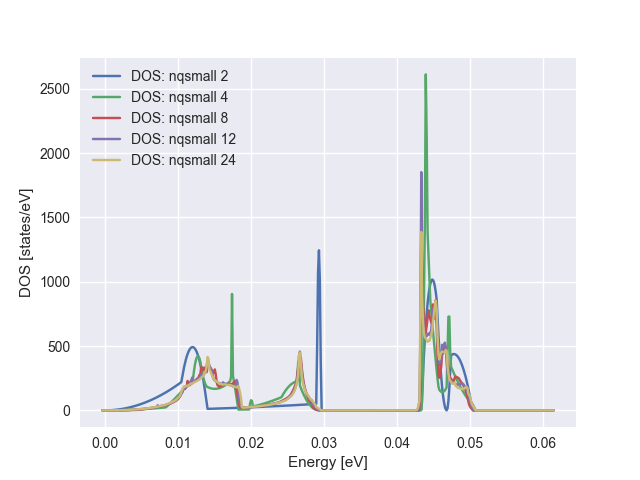

/Users/gmatteo/anaconda3/envs/env3.6/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-10-13 01:18:04.117344. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
c = ddb.anacompare_phdos(nqsmalls=[2, 4, 8, 12, 24])
c.plotter.combiplot();

Anaddb requires the specification of the q-mesh used for the phonons.
The DDB object will try to figure out the number of divisions in the 
mesh from ddb.qpoints.
This information is used to generate automatically the Anaddb input file
Note, however, that if `guessed_ngqpt` is wrong, you will have to pass
this value to all the ddb methods that invoke anaddb.
This could happen if you have merged DDB files computed with $q$-points that do not belong to same grid. 

In [16]:
ddb.guessed_ngqpt

array([4, 4, 4])

/Users/gmatteo/anaconda3/envs/env3.6/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-10-13 01:17:56.915682. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Macroscopic dielectric tensor and Born effective charges (BECs)

In [15]:
emacro, becs = ddb.anaget_emacro_and_becs(chneut=1)

In [16]:
emacro

(Tensor in r space.
 
 Cartesian coordinates:
 [[  1.00000000e+00   1.11022302e-16   1.11022302e-16]
  [  1.11022302e-16   1.00000000e+00   1.11022302e-16]
  [  1.11022302e-16   1.11022302e-16   1.00000000e+00]],)

What's happening here? According to anaddb, AlAs should have a dielectric 
constant of one and this is cleary wrong!
Remember that the computation macroscopic dielectric requires the knowledge 
of $\dfrac{d u_k}{d k}$ (the so-called DDK files)

# Using `DdbRobot` to perform converge studies

Robots are extremely useful if you want to study the convergence of the phonon frequencies at with respect to some computational parameter e.g. `ecut`. 
A `DddRobot` receives a list of DDB files, extracts the data and provides tools to analyze 
the convergence or low-level tools that are just returning a `Pandas` dataframe. 

In [18]:
files = [
        "flow_qconv/w1/outdata/out_DDB",
        "flow_qconv/w3/outdata/out_DDB",
        "flow_qconv/w5/outdata/out_DDB",
        "flow_qconv/w7/outdata/out_DDB",
        "flow_qconv/w9/outdata/out_DDB",
    ]
from abipy.abio.robots import DdbRobot
robot = DdbRobot()
for i, f in enumerate(files):
    robot.add_file(str(i), f) 
print(robot)

frame = robot.get_dataframe_at_qpoint()
print(frame)

FileNotFoundError: [Errno 2] No such file or directory: 'flow_qconv/w1/outdata/out_DDB'

/Users/gmatteo/anaconda3/envs/env3.6/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-10-13 01:18:55.996858. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [42]:
robot.plot_conv_phfreqs_qpoint(x_vars=["ecut"], size=1, aspect=.5)

IndexError: list index out of range